# Autoregressive Model Testing

## Notes for revision:
- Use ADF to determine if the data is stationary
- If the data is not stationary, use ACF， PACF to determine the difference
- AR(order, difference, moving average), start with order 1
- Issue: negative R^2 meaning the model is not converging

RMSE reduced by: 
- 13.19% by adding Bitcoin volitility in GDP AR prediction
- 10.86% by adding USD Coin volitility in GDP AR prediction


In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [23]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Testing all combinations

In [24]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
order = 1
train_end = '2023-05-01'
train_start = '2017-09-01'

results_list = []

In [25]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'q': 0}
ar_orders['CPI'] = {'p': 1, 'q': 0}
ar_orders['r'] = {'p': 1, 'q': 0}
ar_orders['M1'] = {'p': 1, 'q': 0}
ar_orders['GDP Monthly'] = {'p': 1, 'q': 2}
ar_orders['IM'] = {'p': 3, 'q': 0}
ar_orders['EX'] = {'p': 3, 'q': 0}
ar_orders['CC'] = {'p': 2, 'q': 0}
ar_orders['CC Monthly % Change'] = {'p': 2, 'q': 0}
ar_orders['VIX'] = {'p': 1, 'q': 0}
ar_orders['MOVE'] = {'p': 1, 'q': 0}

ar_orders['vol_LFPR'] = {'p': 1, 'q': 0}
ar_orders['vol_CPI'] = {'p': 1, 'q': 0}
ar_orders['vol_r'] = {'p': 1, 'q': 0}
ar_orders['vol_M1'] = {'p': 1, 'q': 0}
ar_orders['vol_GDP'] = {'p': 1, 'q': 0}
ar_orders['vol_IM'] = {'p': 1, 'q': 10}
ar_orders['vol_EX'] = {'p': 1, 'q': 0}
ar_orders['vol_CC'] = {'p': 1, 'q': 0}

In [26]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

# Pre-difference all macro variables
for vol_macro in vol_macro_list:
    adf_p = adfuller(df[vol_macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{vol_macro}_diff'] = df[vol_macro].diff()
        adf_p = adfuller(df[f'{vol_macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{vol_macro}_diff_diff'] = df[f'{vol_macro}_diff'].diff()


In [27]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

### Check that all macro has been differenced appropriately 

In [29]:
for macro in macro_list:
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro
    check_stationarity(df[target_col]) 

for vol_macro in vol_macro_list:
    available_cols = df.columns
    if f'{vol_macro}_diff_diff' in available_cols:
        target_col = f'{vol_macro}_diff_diff'
    elif f'{vol_macro}_diff' in available_cols:
        target_col = f'{vol_macro}_diff'
    else:
        target_col = vol_macro
    check_stationarity(df[target_col]) 

ADF test for LFPR_diff: p-value = 0.0000
ADF test for CPI_diff_diff: p-value = 0.0000
ADF test for r_diff_diff: p-value = 0.0000
ADF test for M1_diff: p-value = 0.0000
ADF test for GDP Monthly_diff: p-value = 0.0000
ADF test for IM_diff: p-value = 0.0000
ADF test for EX_diff: p-value = 0.0000
ADF test for CC_diff: p-value = 0.0000
ADF test for CC Monthly % Change: p-value = 0.0000
ADF test for VIX: p-value = 0.0005
ADF test for MOVE_diff: p-value = 0.0000
ADF test for vol_LFPR_diff: p-value = 0.0000
ADF test for vol_CPI_diff: p-value = 0.0000
ADF test for vol_r_diff: p-value = 0.0000
ADF test for vol_M1_diff: p-value = 0.0000
ADF test for vol_GDP_diff: p-value = 0.0000
ADF test for vol_IM_diff_diff: p-value = 0.0000
ADF test for vol_EX_diff: p-value = 0.0042
ADF test for vol_CC_diff: p-value = 0.0000


In [30]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

ADF test for GDP Monthly: p-value = 0.8648


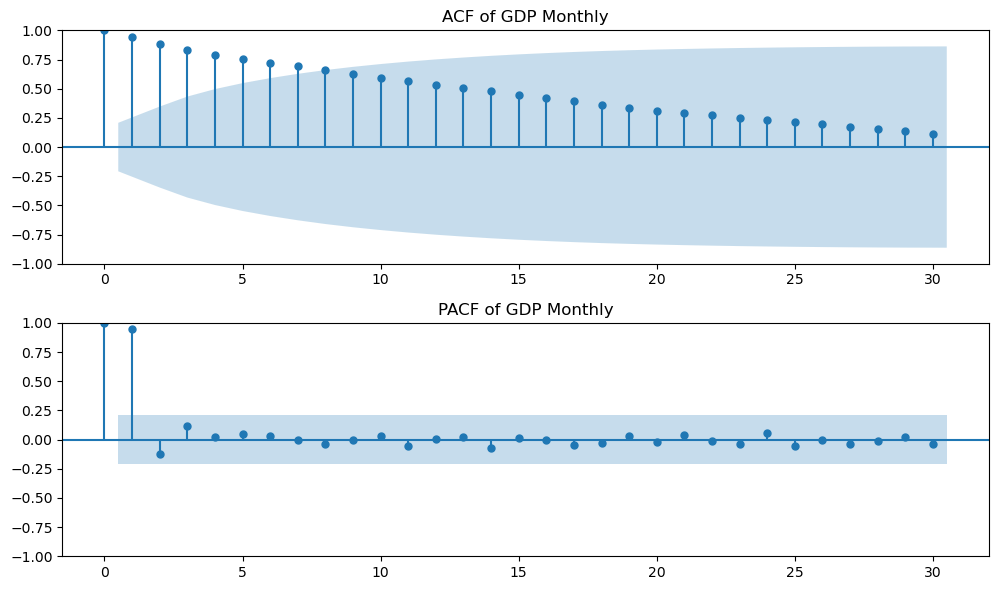

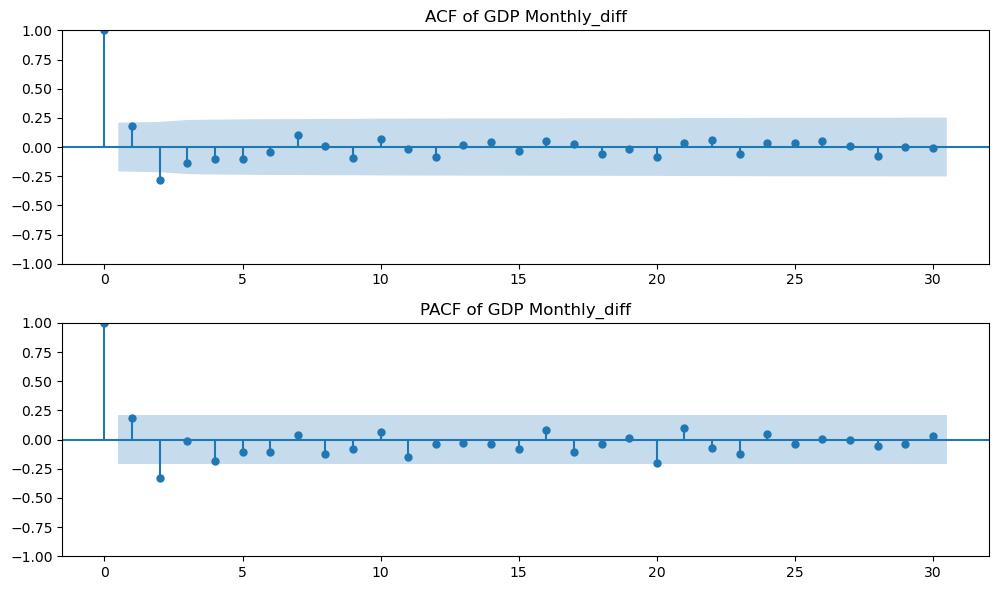

ADF test for GDP Monthly_diff: p-value = 0.0000


6.99968707994161e-13

In [31]:
variable = 'GDP Monthly'
check_stationarity(df[variable])
series = df[variable].dropna()
acf(series, variable)
df[f'{variable}_diff'] = df[variable].diff()
series = df[f'{variable}_diff'].dropna()
acf(series, f'{variable}_diff')
check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

In [32]:
def run_model(df, macro, asset):
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro

    df_temp = df[[target_col, asset]].dropna().copy()
    target = df_temp[target_col]
    exog = df_temp[[asset]]

    # Train/test split
    train_endog = target[:train_end]
    test_endog = target[train_end:]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:]

    order_dict = ar_orders.get(macro, {'p': 1, 'q': 0})  # Default to AR(1) if macro not found
    p = order_dict['p']
    q = order_dict['q']

    # AR model
    ar_model = SARIMAX(train_endog, order=(p, 0, q))
    ar_result = ar_model.fit(disp=False)
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean

    # ARX model
    arx_model = SARIMAX(train_endog, exog=train_exog, order=(p, 0, q))
    arx_result = arx_model.fit(disp=False)
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar),
            'Order': f'({p},0,{q})'
        },
        {
            'Model': 'ARX',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx),
            'Order': f'({p},0,{q})'
        }
    ]

    return metrics

# All Macro & Crypto Combination

In [33]:
results_list = []
# Run through all combinations
for macro in macro_list:
    for asset in asset_list:
        try:
            result_metrics = run_model(df.copy(), macro, asset)
            results_list.extend(result_metrics)
        except Exception as e:
            print(f"Error with {macro}-{asset}: {e}")
            continue

# Final table
results_df = pd.DataFrame(results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2,Order
0,AR,LFPR,Bitcoin,0.0667,0.1069,0.0000,"(1,0,0)"
1,ARX,LFPR,Bitcoin,0.0696,0.1071,-0.0028,"(1,0,0)"
2,AR,LFPR,Tether,0.0667,0.1069,0.0000,"(1,0,0)"
3,ARX,LFPR,Tether,0.0697,0.1072,-0.0047,"(1,0,0)"
4,AR,LFPR,Litecoin,0.0667,0.1069,0.0000,"(1,0,0)"
5,ARX,LFPR,Litecoin,0.0760,0.1098,-0.0555,"(1,0,0)"
6,AR,LFPR,XRP,0.0667,0.1069,0.0000,"(1,0,0)"
7,ARX,LFPR,XRP,0.0723,0.1083,-0.0256,"(1,0,0)"
8,AR,LFPR,Ethereum,0.0667,0.1069,0.0000,"(1,0,0)"
9,ARX,LFPR,Ethereum,0.0750,0.1083,-0.0263,"(1,0,0)"


### Combinations Where Adding Asset Data Improves the Model

In [34]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
20,CPI,Cardano,0.5838,0.5812,0.7738,0.7721,-0.0148,-0.0103
26,CPI,XRP,0.5840,0.5823,0.7740,0.7732,-0.0153,-0.0132
36,GDP Monthly,Bitcoin,88.5950,75.3556,109.2155,94.4716,-0.3849,-0.0363
38,GDP Monthly,Cardano,88.8532,71.1784,109.4538,91.3904,-0.3910,0.0302
39,GDP Monthly,Dogecoin,88.5950,76.6696,109.2155,96.3388,-0.3849,-0.0776
40,GDP Monthly,Ethereum,88.5950,72.2459,109.2155,93.0427,-0.3849,-0.0051
41,GDP Monthly,Litecoin,88.5950,73.8334,109.2155,93.8693,-0.3849,-0.0231
42,GDP Monthly,Tether,88.5950,71.1715,109.2155,92.3130,-0.3849,0.0106
43,GDP Monthly,USD Coin,89.2606,69.1411,109.8457,92.0429,-0.4010,0.0163
44,GDP Monthly,XRP,88.5950,75.0506,109.2155,96.3742,-0.3849,-0.0784


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
0,CC,Bitcoin,3.3383,3.2917,0.0475,0.0062
2,CC,Cardano,3.3430,3.2643,0.0459,-0.0010
3,CC,Dogecoin,3.3383,3.2992,0.0475,0.0092
4,CC,Ethereum,3.3383,3.2813,0.0475,0.0028
5,CC,Litecoin,3.3383,3.3050,0.0475,-0.0117
6,CC,Tether,3.3383,3.3038,0.0475,-0.0159
7,CC,USD Coin,3.3308,3.2824,0.0516,-0.0043
8,CC,XRP,3.3383,3.3182,0.0475,-0.0063
10,CC Monthly % Change,Bitcoin Price,0.0524,0.0517,-0.0508,-0.0961
20,CPI,Cardano,0.5838,0.5812,-0.0148,-0.0103


# All Macro Volitility & Crypto Combination

In [35]:
vol_results_list = []
# Run through all combinations
for vol_macro in vol_macro_list:
    for asset in asset_list:
        try:
            vol_result_metrics = run_model(df.copy(), vol_macro, asset)
            vol_results_list.extend(vol_result_metrics)
        except Exception as e:
            print(f"Error with {vol_macro}-{vol_macro}: {e}")
            continue

# Final table
results_df = pd.DataFrame(vol_results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2,Order
0,AR,vol_LFPR,Bitcoin,0.0001,0.0002,-0.0019,"(1,0,0)"
1,ARX,vol_LFPR,Bitcoin,0.0002,0.0002,-0.2380,"(1,0,0)"
2,AR,vol_LFPR,Tether,0.0001,0.0002,-0.0019,"(1,0,0)"
3,ARX,vol_LFPR,Tether,0.0001,0.0002,-0.0358,"(1,0,0)"
4,AR,vol_LFPR,Litecoin,0.0001,0.0002,-0.0019,"(1,0,0)"
5,ARX,vol_LFPR,Litecoin,0.0002,0.0002,-0.1573,"(1,0,0)"
6,AR,vol_LFPR,XRP,0.0001,0.0002,-0.0019,"(1,0,0)"
7,ARX,vol_LFPR,XRP,0.0002,0.0002,-0.4391,"(1,0,0)"
8,AR,vol_LFPR,Ethereum,0.0001,0.0002,-0.0019,"(1,0,0)"
9,ARX,vol_LFPR,Ethereum,0.0001,0.0002,0.0096,"(1,0,0)"


In [36]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
34,vol_GDP,USD Coin,0.0003,0.0003,0.0005,0.0005,-0.0213,-0.0137
36,vol_IM,Bitcoin,0.0029,0.0027,0.0054,0.0053,-0.1320,-0.0593
37,vol_IM,Bitcoin Price,0.0029,0.0025,0.0054,0.0051,-0.1320,-0.0110
40,vol_IM,Ethereum,0.0029,0.0029,0.0054,0.0054,-0.1320,-0.1227
41,vol_IM,Litecoin,0.0029,0.0027,0.0054,0.0053,-0.1320,-0.0816
42,vol_IM,Tether,0.0029,0.0026,0.0054,0.0052,-0.1320,-0.0526
43,vol_IM,USD Coin,0.0029,0.0023,0.0054,0.0051,-0.1296,-0.0005
69,vol_r,Tether,0.0079,0.0078,0.0125,0.0121,-0.1471,-0.0705


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
34,vol_GDP,USD Coin,0.0003,0.0003,-0.0213,-0.0137
36,vol_IM,Bitcoin,0.0029,0.0027,-0.1320,-0.0593
37,vol_IM,Bitcoin Price,0.0029,0.0025,-0.1320,-0.0110
40,vol_IM,Ethereum,0.0029,0.0029,-0.1320,-0.1227
41,vol_IM,Litecoin,0.0029,0.0027,-0.1320,-0.0816
42,vol_IM,Tether,0.0029,0.0026,-0.1320,-0.0526
43,vol_IM,USD Coin,0.0029,0.0023,-0.1296,-0.0005
69,vol_r,Tether,0.0079,0.0078,-0.1471,-0.0705


# Testing GDP Volitility

## Plotting Individual Conbination

In [37]:
macro = 'GDP Monthly'
asset = 'Bitcoin'

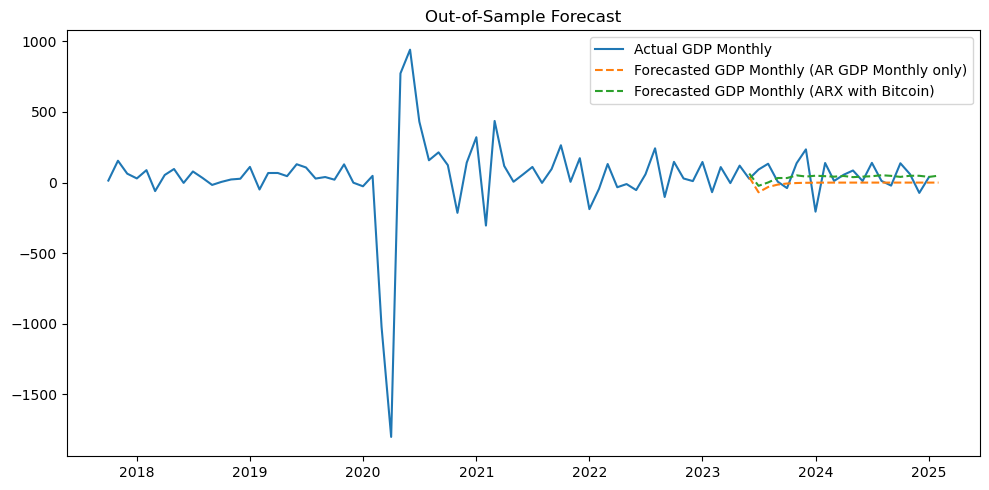

                               SARIMAX Results                                
Dep. Variable:       GDP Monthly_diff   No. Observations:                   68
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -482.425
Date:                Mon, 23 Jun 2025   AIC                            972.850
Time:                        14:44:21   BIC                            981.728
Sample:                    10-01-2017   HQIC                           976.367
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4555      0.249      1.831      0.067      -0.032       0.943
ma.L1         -0.1850      0.265     -0.697      0.486      -0.705       0.335
ma.L2         -0.4390      0.163     -2.690      0.0

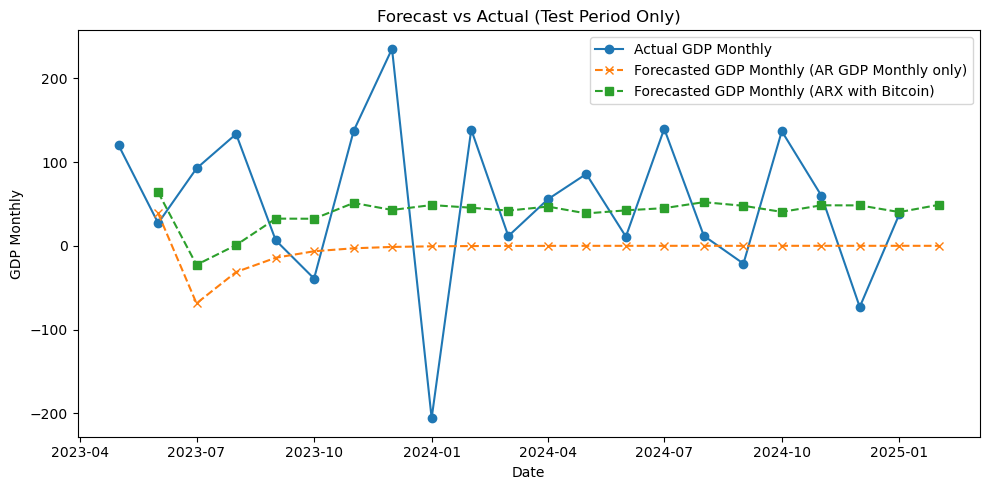

In [38]:
available_cols = df.columns
if f'{macro}_diff_diff' in available_cols:
    target_col = f'{macro}_diff_diff'
elif f'{macro}_diff' in available_cols:
    target_col = f'{macro}_diff'
else:
    target_col = macro

df_temp = df[[target_col, asset]].dropna().copy()

### new
# df_temp['asset_lag1'] = df_temp[asset].shift(1)  # t-1
# df_temp['asset_lag2'] = df_temp[asset].shift(2)  # t-2 (optional)
# df_temp = df_temp.dropna()

target = df_temp[target_col]

exog = df_temp[[asset]]
# exog = df_temp[[asset, 'asset_lag1']].dropna()
# exog = df_temp[[asset, 'asset_lag1','asset_lag2']].dropna()
# exog = df_temp[[asset, 'LFPR', 'r']].dropna()


# Train/test split
train_endog = target[:train_end]
test_endog = target[train_end:]
train_exog = exog[:train_end]
test_exog = exog[train_end:]

order_dict = ar_orders.get(macro, {'p': 1, 'q': 0})  # Default to AR(1) if macro not found
p = order_dict['p']
q = order_dict['q']

# AR model
ar_model = SARIMAX(train_endog, order=(p, 0, q))
ar_result = ar_model.fit(disp=False)
forecast_ar = ar_result.get_forecast(steps=len(test_endog))
pred_ar = forecast_ar.predicted_mean
conf_int_ar = forecast_ar.conf_int() 

# ARX model
arx_model = SARIMAX(train_endog, exog=train_exog, order=(p, 0, q))
arx_result = arx_model.fit(disp=False)
forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
pred_arx = forecast_arx.predicted_mean
conf_int_arx = forecast_arx.conf_int()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual ' + macro)
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--')
# plt.fill_between(
#     pred_ar.index,
#     conf_int_ar.iloc[:, 0],  # Lower bound
#     conf_int_ar.iloc[:, 1],   # Upper bound
#     color='blue',
#     alpha=0.1,
#     label='AR 95% CI'
# )
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--')
# plt.fill_between(
#     pred_arx.index,
#     conf_int_arx.iloc[:, 0],  # Lower bound
#     conf_int_arx.iloc[:, 1],  # Upper bound
#     color='red',
#     alpha=0.1,
#     label='ARX 95% CI'
# )
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()

# Printing stats 
mae_ar = mean_absolute_error(test_endog, pred_ar)
rmse_ar = np.sqrt(mean_squared_error(test_endog, pred_ar))
r2_ar = r2_score(test_endog, pred_ar)
print(ar_result.summary())
print(arx_result.summary())

mae_arx = mean_absolute_error(test_endog, pred_arx)
rmse_arx = np.sqrt(mean_squared_error(test_endog, pred_arx))
r2_arx = r2_score(test_endog, pred_arx)

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}\n")

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")

# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o')
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x')
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()


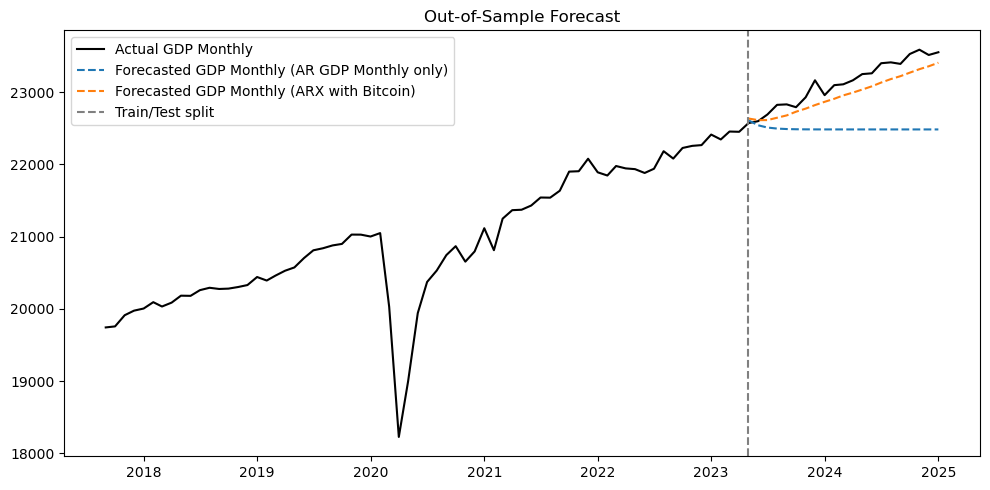

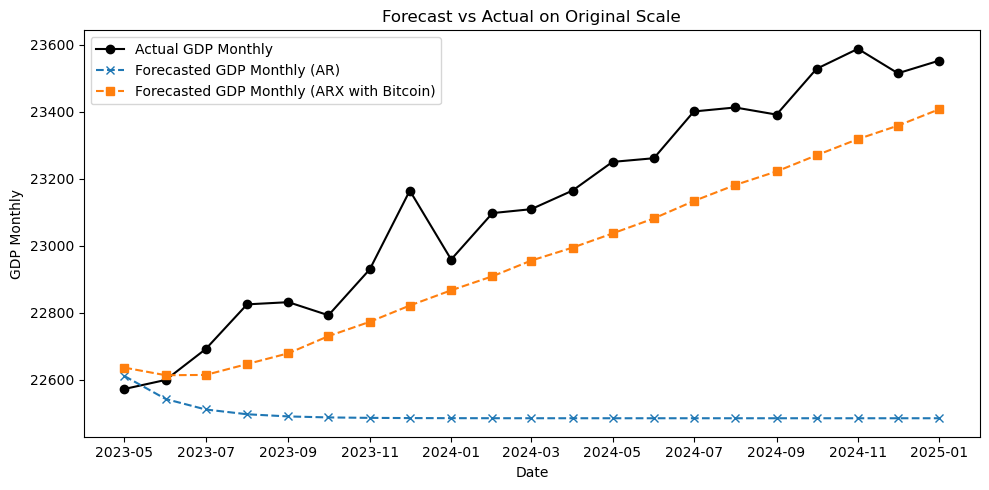

AR model test set evaluation:
  MAE:  633.6739
  RMSE: 713.5543
  R²:   -4.0797
  MAPE: 2.72%

ARX model test set evaluation:
  MAE:  168.8478
  RMSE: 185.8768
  R²:   0.6553
  MAPE: 0.73%


In [39]:
if target_col != macro:
    # Get the last known value before the test period
    last_train_value = df[macro].loc[train_endog.index[-1]]

    # Reconstruct forecasted levels
    pred_ar_original = last_train_value + pred_ar.cumsum()
    pred_ar_original.index = test_endog.index 

    pred_arx_original = last_train_value + pred_arx.cumsum()
    pred_arx_original.index = test_endog.index

    # Actual values on original scale for test period
    actual_original = df[macro].loc[test_endog.index]
else:
    # No differencing used
    pred_ar_original = pred_ar
    pred_arx_original = pred_arx
    actual_original = test_endog

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df[macro], label='Actual ' + macro, color = 'black')
plt.plot(pred_ar_original, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--')
plt.plot(pred_arx_original, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--')
# Add vertical line separating train and test
plt.axvline(x=test_endog.index[0], color='gray', linestyle='--', linewidth=1.5, label='Train/Test split')

plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(actual_original, label='Actual ' + macro, marker='o', color = 'black')
plt.plot(pred_ar_original, label='Forecasted ' + macro + f' (AR)', linestyle='--', marker='x')
plt.plot(pred_arx_original, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s')
plt.title("Forecast vs Actual on Original Scale")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()

# Printing stats 
mae_ar = mean_absolute_error(df[macro].loc[test_endog.index], pred_ar_original)
rmse_ar = np.sqrt(mean_squared_error(df[macro].loc[test_endog.index], pred_ar_original))
r2_ar = r2_score(df[macro].loc[test_endog.index], pred_ar_original)
mape_ar = mean_absolute_percentage_error(actual_original, pred_ar_original)

mae_arx = mean_absolute_error(actual_original, pred_arx_original)
rmse_arx = np.sqrt(mean_squared_error(actual_original, pred_arx_original))
r2_arx = r2_score(actual_original, pred_arx_original)
mape_arx = mean_absolute_percentage_error(actual_original, pred_arx_original)

# print(ar_result.summary())
# print(arx_result.summary())

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}")
print(f"  MAPE: {mape_ar:.2f}%\n")

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")
print(f"  MAPE: {mape_arx:.2f}%")